In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import GroupShuffleSplit # ensures don't mix series
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression

df = pd.read_csv("../data/processed/cleaned_data.csv")


In [7]:
features = ["score_ep1", "ppt_ep1"] 
target = "final_pct_points"
groups = df["Series"] 

In [28]:
# Create a Group shuffle split object using library imported above

gss = GroupShuffleSplit(
    n_splits=1,
    test_size=0.2,  
    random_state=42
)


train_idx, test_idx = next(
    gss.split(df[features], df[target], groups))


X_train = df.loc[train_idx, features]

X_test = df.loc[test_idx, features]

y_train = df.loc[train_idx, target]

y_test = df.loc[test_idx, target]

In [32]:
# Calculate the baseline prediction.
baseline_prediction = y_train.mean()

# Create an array of baseline predictions for the test set.
y_pred_baseline = np.full_like(y_test, baseline_prediction)

# Normalise results
# Combine test set information into a single df
y_pred_baseline_norm = X_test.copy()  # start with  features of test set
y_pred_baseline_norm["Series"] = df.loc[test_idx, "Series"]          # add series info
y_pred_baseline_norm["Predicted_Final_Pct_Raw"] = y_pred_baseline                # add model predictions
y_pred_baseline_norm["Predicted_Final_Pct_Norm"] = 0

# normalise results
y_pred_baseline_norm["Predicted_Final_Pct_Norm"] = (y_pred_baseline_norm.groupby("Series")["Predicted_Final_Pct_Raw"].transform(lambda x: x / x.sum()))

# drop all other columns
y_pred_baseline_norm = y_pred_baseline_norm["Predicted_Final_Pct_Norm"]

mae_baseline = mean_absolute_error(y_test, y_pred_baseline_norm)
rmse_baseline = mean_squared_error(y_test, y_pred_baseline_norm, squared=False)

# Print the baseline error metrics, rounded to three decimal places.
# These values tell us how our very basic model (using averages) performs.

mae_baseline_format = (mae_baseline * 100).round(1).astype(str) + "%"
rmse_baseline_format = (rmse_baseline * 100).round(1).astype(str) + "%"

print(f"Baseline MAE: {mae_baseline_format} (percentage points)")
print(f"Baseline RMSE: {rmse_baseline_format} (percentage points)")




Baseline MAE: 1.5%
Baseline RMSE: 1.8%


In [33]:
plot_df_baseline = df.loc[test_idx, [
    "Contestant",
    "Series",
    target
]].copy()

plot_df_baseline["actual"] = y_test.values
plot_df_baseline["predicted_norm"] = y_pred_baseline_norm

plot_df_baseline = plot_df_baseline.drop(['final_pct_points'], axis=1)

plot_df_baseline = plot_df_baseline.sort_values(
    by=["Series", "actual"],
    ascending=[True, True])

plot_df_baseline

,Contestant,Series,actual,predicted_norm
2,Roisin Conaty,1,0.1560,0.2
4,Tim Key,1,0.2018,0.2
0,Frank Skinner,1,0.2133,0.2
3,Romesh Ranganathan,1,0.2133,0.2
1,Josh Widdicombe,1,0.2156,0.2
6,Joe Wilkinson,2,0.1655,0.2
5,Doc Brown,2,0.1871,0.2
9,Richard Osman,2,0.2062,0.2
7,Jon Richardson,2,0.2158,0.2
8,Katherine Ryan,2,0.2254,0.2


In [34]:
placement_df_baseline = plot_df_baseline.copy()

placement_df_baseline["actual_placement"] = (
    placement_df_baseline
    .groupby("Series")["actual"]
    .rank(ascending=False, method="min")
    .astype(int)
)

placement_df_baseline["predicted_placement"] = (
    placement_df_baseline
    .groupby("Series")["predicted_norm"]
    .rank(ascending=False, method="min")
    .astype(int)
)

placement_df_baseline["placement_error"] = (
    placement_df_baseline["predicted_placement"]
    - placement_df_baseline["actual_placement"]
)

placement_table_baseline = placement_df_baseline[[
    "Contestant",
    "Series",
    "actual",
    "predicted_norm",
    "actual_placement",
    "predicted_placement",
    "placement_error"]].sort_values(by=["Series", "actual_placement"])

mean_abs_placement_error_baseline = placement_df_baseline["placement_error"].abs().mean()

print(f"Mean absolute placement error: {mean_abs_placement_error_baseline:.2f}")

exact_matches = (placement_df_baseline["placement_error"] == 0).sum()

print(f"Exact placement matches: {exact_matches} out of {len(placement_df_baseline)}")

placement_table_baseline.style.applymap(
    lambda x: "background-color: #c8e6c9" if x == 0 else "",
    subset=["placement_error"])


Mean absolute placement error: 1.95
Exact placement matches: 4 out of 20


,Contestant,Series,actual,predicted_norm,actual_placement,predicted_placement,placement_error
1,Josh Widdicombe,1,0.215600,0.200000,1,1,0
0,Frank Skinner,1,0.213300,0.200000,2,1,-1
3,Romesh Ranganathan,1,0.213300,0.200000,2,1,-1
4,Tim Key,1,0.201800,0.200000,4,1,-3
2,Roisin Conaty,1,0.156000,0.200000,5,1,-4
8,Katherine Ryan,2,0.225400,0.200000,1,1,0
7,Jon Richardson,2,0.215800,0.200000,2,1,-1
9,Richard Osman,2,0.206200,0.200000,3,1,-2
5,Doc Brown,2,0.187100,0.200000,4,1,-3
6,Joe Wilkinson,2,0.165500,0.200000,5,1,-4


In [9]:
# Create a new linear regression model 
model = LinearRegression()

model.fit(X_train, y_train)

LinearRegression()

In [11]:
# using the TEST explanatory variables, use the model to estimate the outcome for each contestant (in y_pred)
# Normalise results as in previous workings

y_pred = model.predict(X_test)

# Combine test set information into a single df
y_pred_norm = X_test.copy()  # start with  features of test set
y_pred_norm["Series"] = df.loc[test_idx, "Series"]          # add series info
y_pred_norm["Predicted_Final_Pct_Raw"] = y_pred                # add model predictions
y_pred_norm["Predicted_Final_Pct_Norm"] = 0

# normalise results
y_pred_norm["Predicted_Final_Pct_Norm"] = (y_pred_norm.groupby("Series")["Predicted_Final_Pct_Raw"].transform(lambda x: x / x.sum()))

# drop all other columns
y_pred_norm = y_pred_norm["Predicted_Final_Pct_Norm"]

mae = mean_absolute_error(y_test, y_pred_norm)
rmse = mean_squared_error(y_test, y_pred_norm, squared=False)

print(f"Linear Regression MAE: {mae:.3f}")

print(f"\nLinear Regression RMSE: {rmse:.3f}")


Linear Regression MAE: 0.010

Linear Regression RMSE: 0.013


In [20]:
# add contestant and series to the dataframe for plotting
plot_df = df.loc[test_idx, [
    "Contestant",
    "Series",
    target
]].copy()

plot_df["actual"] = y_test.values
plot_df["predicted_norm"] = y_pred_norm

plot_df = plot_df.drop(['final_pct_points'], axis=1)

plot_df = plot_df.sort_values(
    by=["Series", "actual"],
    ascending=[True, True])

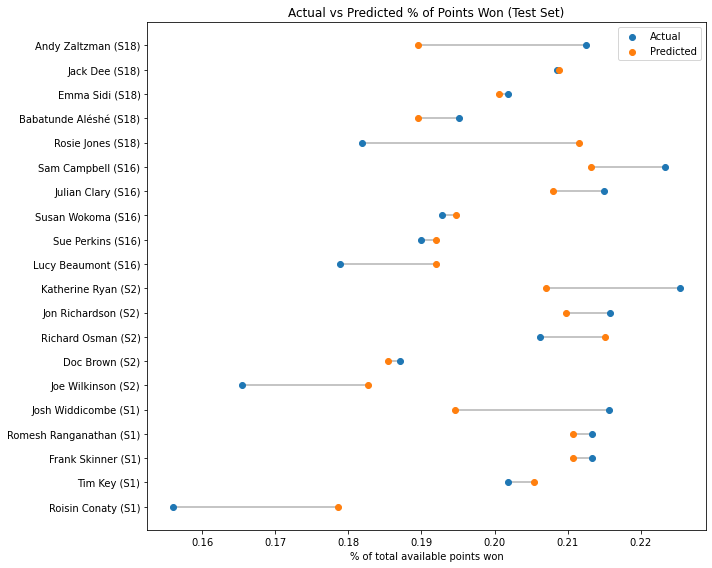

In [21]:
# Set up x axis position

y_pos = np.arange(len(plot_df))

plt.figure(figsize=(10, 0.4 * len(plot_df)))

# Lines
plt.hlines(
    y=y_pos,
    xmin=plot_df["actual"],
    xmax=plot_df["predicted_norm"],
    color="grey",
    alpha=0.6
)

# Actual values
plt.scatter(
    plot_df["actual"],
    y_pos,
    label="Actual",
    zorder=3
)

# Predicted values
plt.scatter(
    plot_df["predicted_norm"],
    y_pos,
    label="Predicted",
    zorder=3
)

# Y-axis labels
plt.yticks(
    y_pos,
    plot_df["Contestant"] + " (S" + plot_df["Series"].astype(str) + ")"
)

plt.xlabel("% of total available points won")
plt.title("Actual vs Predicted % of Points Won (Test Set)")
plt.legend()
plt.tight_layout()
plt.show()

In [26]:
# print(plot_df)

placement_df = plot_df.copy()

placement_df["actual_placement"] = (
    placement_df
    .groupby("Series")["actual"]
    .rank(ascending=False, method="min")
    .astype(int)
)

placement_df["predicted_placement"] = (
    placement_df
    .groupby("Series")["predicted_norm"]
    .rank(ascending=False, method="min")
    .astype(int)
)

placement_df["placement_error"] = (
    placement_df["predicted_placement"]
    - placement_df["actual_placement"]
)

placement_table = placement_df[[
    "Contestant",
    "Series",
    "actual",
    "predicted_norm",
    "actual_placement",
    "predicted_placement",
    "placement_error"]].sort_values(by=["Series", "actual_placement"])

mean_abs_placement_error = placement_df["placement_error"].abs().mean()

print(f"Mean absolute placement error: {mean_abs_placement_error:.2f}")

exact_matches = (placement_df["placement_error"] == 0).sum()

print(f"Exact placement matches: {exact_matches} out of {len(placement_df)}")

placement_table.style.applymap(
    lambda x: "background-color: #c8e6c9" if x == 0 else "",
    subset=["placement_error"])



# placement_table

Mean absolute placement error: 0.90
Exact placement matches: 11 out of 20


,Contestant,Series,actual,predicted_norm,actual_placement,predicted_placement,placement_error
1,Josh Widdicombe,1,0.215600,0.194632,1,4,3
0,Frank Skinner,1,0.213300,0.210736,2,1,-1
3,Romesh Ranganathan,1,0.213300,0.210736,2,1,-1
4,Tim Key,1,0.201800,0.205368,4,3,-1
2,Roisin Conaty,1,0.156000,0.178528,5,5,0
8,Katherine Ryan,2,0.225400,0.207035,1,3,2
7,Jon Richardson,2,0.215800,0.209741,2,2,0
9,Richard Osman,2,0.206200,0.215153,3,1,-2
5,Doc Brown,2,0.187100,0.185389,4,4,0
6,Joe Wilkinson,2,0.165500,0.182683,5,5,0
